In [71]:
### Install and import libraries

In [1]:
!pip install ogb
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html


In [2]:
import torch_geometric
import networkx as nx
import random
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling
from shared_code import PICKLE_PATH, color

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
dataset = PygLinkPropPredDataset(name = 'ogbl-ddi')
evaluator = Evaluator(name='ogbl-ddi')

split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
graph = dataset[0]
g = torch_geometric.utils.to_networkx(graph, to_undirected=True)

In [4]:
print("Number of edges in the training set: ", train_edge['edge'].shape[0])
print("Number of edges in the validation set: ")
print("\t positive: ", valid_edge['edge'].shape[0])
print("\t negative: ", valid_edge['edge_neg'].shape[0])
print("Number of edges in the test set: ")
print("\t positive: ", test_edge['edge'].shape[0])
print("\t negative: ", test_edge['edge_neg'].shape[0])

Number of edges in the training set:  1067911
Number of edges in the validation set: 
	 positive:  133489
	 negative:  101882
Number of edges in the test set: 
	 positive:  133489
	 negative:  95599


### Compute general statistics

In [ ]:
print("Diameter: ", nx.diameter(g)) # takes ~13.5mins on MCB Pro '19

In [10]:
print("Average clustering coefficient: ", nx.average_clustering(g)) # takes ~5mins on MCB Pro '19

Average clustering coefficient:  0.5142590776306287


In [12]:
print("Average shortest path length: ", nx.average_shortest_path_length(g)) # takes ~14mins on MCB Pro '19

Average shortest path length:  2.125111863293908


In [82]:
average_degree = sum([g.degree(n) for n in g.nodes()])/len(g.nodes())
print("Average degree: ", average_degree)

Average degree:  500.5441762362315


In [83]:
import math
N = len(g.nodes())
print("Expected average distance acc to small worlds", math.log(N)/math.log(average_degree))

Expected average distance acc to small worlds 1.344767580767809


In [15]:
nx.density(g)

0.11733337464515507

In [16]:
N

4267

In [17]:
average_degree

500.5441762362315

In [19]:
nx.transitivity(g)

0.46811303106318475

In [45]:
nx.algebraic_connectivity(g)

0.7811786582444179

In [84]:
# BA stats (Lecture notes BA model, slide 29)
BA_t = N
BA_m = 250
BA_L = BA_t * BA_m
BA_k = 2*BA_m
BA_d = np.round(math.log(N)/math.log(math.log(N)),3)
BA_C = np.round(math.log(N)** 2 / N,3)
print(f'BA Model: N={BA_t}, L={BA_L}, k={BA_k}, d={BA_d}, C={BA_C}')

BA Model: N=4267, L=1066750, k=500, d=3.937, C=0.016


### Compute node attributes (careful: very slow)

In [36]:
nx.set_node_attributes(g, nx.betweenness_centrality(g), "betweenness")

In [37]:
nx.set_node_attributes(g, nx.eigenvector_centrality(g), "eigenvect")

In [67]:
nx.set_node_attributes(g, nx.clustering(g), "clust")

In [56]:
nx.set_node_attributes(g, nx.degree_centrality(g), "degree_centr")

In [57]:
nx.set_node_attributes(g, nx.centrality.subgraph_centrality(g), "subg_centr")

/usr/local/Caskroom/miniconda/base/envs/ada/lib/python3.8/site-packages/networkx/algorithms/centrality/subgraph_alg.py:182: RuntimeWarning: overflow encountered in exp
  expw = np.exp(w)


In [67]:
nx.set_node_attributes(g, nx.centrality.closeness_centrality(g), "closeness_centr")

In [70]:
PICKLE_PATH  = './latest_graph.pickle'
nx.write_gpickle(g, path=PICKLE_PATH)

In [11]:
betw = nx.get_node_attributes(g,'betweenness')
eigc = nx.get_node_attributes(g,'eigenvect')
degc = nx.get_node_attributes(g,'degree_centr')
subgc = nx.get_node_attributes(g,'subg_centr')


In [12]:
import pandas as pd
pd.DataFrame.from_dict(betw, orient='index').describe()

,0
count,4267.000000
mean,0.000264
std,0.001005
min,0.000000
25%,0.000003
50%,0.000044
75%,0.000251
max,0.050463


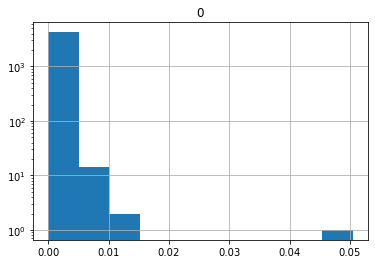

In [13]:
import matplotlib.pyplot as plt
pd.DataFrame.from_dict(betw, orient='index').hist()
plt.yscale('log')

                  0
count  4.267000e+03
mean   1.133117e-02
std    1.029495e-02
min    1.092451e-07
25%    1.148121e-03
50%    9.299999e-03
75%    1.859486e-02
max    4.666307e-02


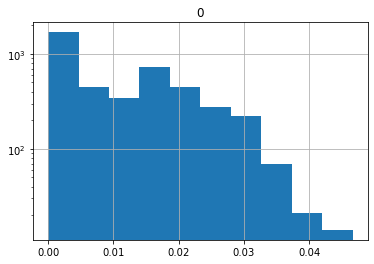

In [14]:
print(pd.DataFrame.from_dict(eigc, orient='index').describe())
pd.DataFrame.from_dict(eigc, orient='index').hist()
plt.yscale('log')

                 0
count  4267.000000
mean      0.117333
std       0.098577
min       0.000234
25%       0.025668
50%       0.104548
75%       0.180497
max       0.523676


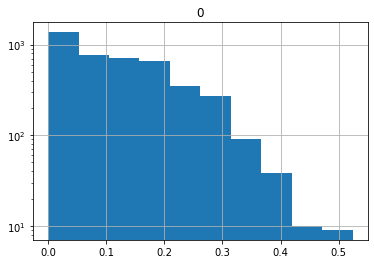

In [15]:
print(pd.DataFrame.from_dict(degc, orient='index').describe())
pd.DataFrame.from_dict(degc, orient='index').hist()
plt.yscale('log')

### Degree distribution analysis

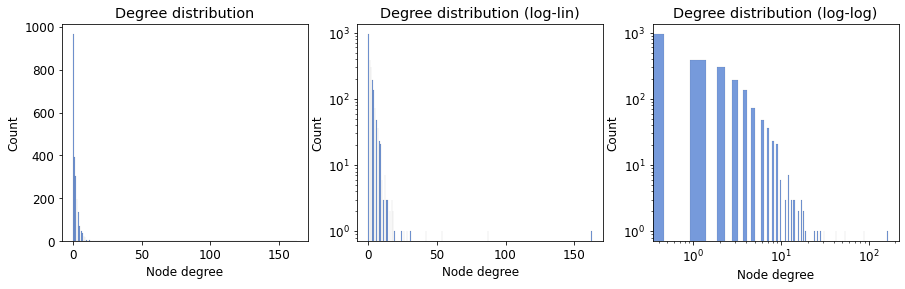

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
axs = ax.ravel()

hist = nx.degree_histogram(g)
sns.histplot(hist, ax=axs[0])
axs[0].set_title('Degree distribution')
axs[0].set_xlabel('Node degree')

sns.histplot(hist, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Degree distribution (log-lin)')
axs[1].set_xlabel('Node degree')

sns.histplot(hist, ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_title('Degree distribution (log-log)')
axs[2].set_xlabel('Node degree')

plt.show()

0.0025


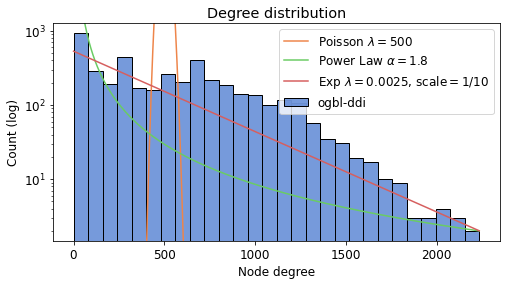

In [77]:
degrees = [g.degree(n) for n in g.nodes()]



import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import math

# Create a Poisson distro (I want to show it fits badly)
mu = np.average(degrees)
k =np.arange(0,max(degrees))
pmf = poisson.pmf(k, mu=mu) * sum(degrees)

# Generate the points manually because I couldnt get the powerlaw package to just do it
alph  = 1.8
C = 1
pl_fit = np.arange(0,max(degrees), dtype=float)
for x in range(1,len(pl_fit)):
    pl_fit[x] = C*(x**(-alph) * sum(degrees))
pl_fit[0] = pl_fit[1]

exponential_fit = np.arange(0,max(degrees), dtype=float)
_lambda = 0.0025 #np.round(math.log(1/mu + 1), 4)
print(_lambda)
for x in range(len(exponential_fit)):
    exponential_fit[x] = _lambda*math.exp(-_lambda * x) * sum(degrees) / 10


color = sns.color_palette("muted", as_cmap=True)
sns.set_palette(color)
fig = plt.figure(figsize=(8, 4))
degrees = [g.degree(n) for n in g.nodes()]
sns.histplot(degrees, label='ogbl-ddi')
plt.yscale('log')
bot, top = plt.ylim()
plt.plot(k, pmf, color=color[1], label='Poisson $\lambda = 500$')
plt.plot(k, pl_fit, color=color[2], label=f'Power Law $ \\alpha = {alph}$')
plt.plot(k, exponential_fit, color=color[3], label=f'Exp $ \lambda = {_lambda}$, scale$=1/10$')
plt.title('Degree distribution')
plt.xlabel('Node degree')
plt.ylabel('Count (log)')
plt.ylim((bot, top)) # Restore lims from above to focus on our graph
plt.legend()
plt.savefig("degree_dist.pdf")


In [79]:
min(degrees), max(degrees), np.median(degrees)

(1, 2234, 446.0)

### Neighbourhood Overlap Analysis

In [92]:
nodes = list(g.nodes())
raw_probas = {}
jaccard_probas = {}

for (i, node_a) in enumerate(nodes):
    if i % 50 == 0: print(i)
    if node_a == nodes[-1]: break
    for node_b in nodes[i+1:]:
        neigh_a = set(g.neighbors(node_a))
        neigb_b = set(g.neighbors(node_b))
        intersection = len(list(neigh_a.intersection(neigb_b)))
        union = len(list(neigh_a.union(neigb_b)))
        jaccard = np.round(intersection/union,2)
        are_linked = int(node_b in neigh_a)
        raw_probas[intersection] = raw_probas.get(intersection) or {}
        jaccard_probas[jaccard] = jaccard_probas.get(jaccard) or {}
        raw_probas[intersection]['total'] = (raw_probas[intersection].get('total') or 0) + 1
        raw_probas[intersection]['avg'] = ((raw_probas[intersection].get('avg') or 0)*(raw_probas[intersection]['total']-1) + are_linked)/raw_probas[intersection]['total']
        jaccard_probas[jaccard]['total'] = (jaccard_probas[jaccard].get('total') or 0) + 1
        jaccard_probas[jaccard]['avg'] = ((jaccard_probas[jaccard].get('avg') or 0)*(jaccard_probas[jaccard]['total']-1) + are_linked)/jaccard_probas[jaccard]['total']


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250


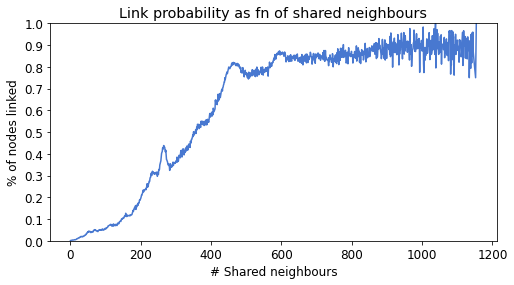

In [64]:


raw_df = pd.DataFrame.from_dict(raw_probas,orient='index').sort_index()
plt.plot(raw_df[raw_df['total']>20]['avg'], color=color[0])
plt.title('Link probability as fn of shared neighbours')
plt.xlabel('# Shared neighbours')
plt.ylabel('% of nodes linked')
plt.ylim((0,1.0))
plt.yticks(np.linspace(start=0,stop=1.0,num=11))
plt.savefig("neighbour_anal.pdf")


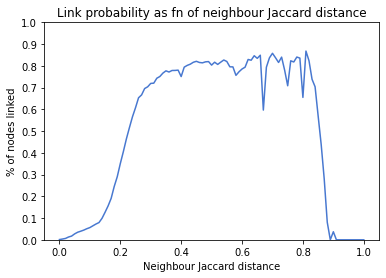

In [22]:
jaccard_df = pd.DataFrame.from_dict(jaccard_probas,orient='index').sort_index()

plt.plot(jaccard_df[jaccard_df['total']>20]['avg'], color=color[0])
plt.title('Link probability as fn of neighbour Jaccard distance')
plt.xlabel('Neighbour Jaccard distance')
plt.ylabel('% of nodes linked')
plt.ylim((0,1.0))
plt.yticks(np.linspace(start=0,stop=1.0,num=11))
plt.show()

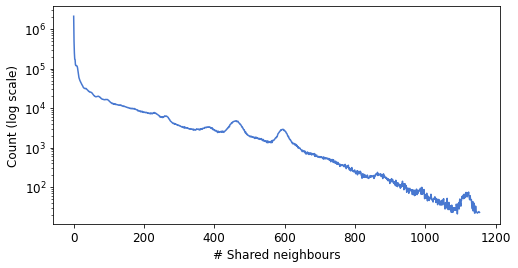

In [65]:
plt.figure(figsize=(8,4))
plt.plot(raw_df[raw_df['total']>20]['total'], color=color[0])
plt.title('')
plt.xlabel('# Shared neighbours')
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.savefig("neighbour_deg.pdf")
